In [1]:
#@title Load station and meteorological model. Save fusion file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import seaborn as sns

path_result = "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/LEVXfusion1.csv"

def transform_value_l(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

def transform_value_m(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CM{first_decimal}'

def transform_to_nearest_odd(arr):
    # Make a copy of the input array
    arr_copy = arr.copy()

    # Find even numbers
    even_indices = arr_copy % 2 == 0

    # Increment even numbers to the nearest odd number
    arr_copy[even_indices] += 1

    return arr_copy.astype(str)

def custom_round(value):
    if value > 9001:
        return str(9999)
    elif value < 1000:
        return str(500)
    else:
        return str(round(value / 1000) * 1000)



pd.options.display.max_rows = 999

station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          parse_dates=["time"]).dropna().set_index("time")

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2022.csv",parse_dates=["time"])
df_all = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")


#wind direction to words
df_all["dir0_l"] = result = ["0" + c if len(c) == 2 else ("00" + c if len(c) == 1 else c) for c in (round(df_all["dir0"],-1).astype(int).astype(str))]
all = round(df_all["mod0"] * 1.94384, 0).astype(int).values
list_mod0 = ["0" + str(c) if len(c) == 1 else str(c) for c in transform_to_nearest_odd(all)]
df_all["wind"]=df_all["dir0_l"]+list_mod0+"kt"

#visibility words
"""
interval = pd.IntervalIndex.from_tuples([(-1.5, 20000),(20000,30000)])
labels = ['vi20d', 'vi20u']
df_all["visibility0_l"] = pd.cut(df_all["visibility0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["visibility0_l","visibility0"]].sample(100)
"""
# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_all['visibility0_l'] = ((a * df_all['visibility0'] + b).round().astype(int)).apply(custom_round)

#rh in words
interval = pd.IntervalIndex.from_tuples([(-1.5, .80),(.80,100)])
labels = ['rhd80', 'rhu80']
df_all["rh0_l"] = pd.cut(df_all["rh0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["rh0_l","rh0"]].sample(100)


#prec words
interval = pd.IntervalIndex.from_tuples([(-1.5, 0.1),(.1,180)])
labels = ['prec0n', 'prec0y']
df_all["prec0_l"] = pd.cut(df_all["prec0"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype("str")
df_all[["prec0_l","prec0"]].sample(100)


#cfl words
df_all['cfl0_l'] = round(df_all["cfl0"],1).apply(transform_value_l)

#cfm words
df_all['cfm0_l'] = round(df_all["cfm0"],1).apply(transform_value_m)


#temp words
df_all["temp0_l"] = ["0" + c if len(c) == 1 else c for c in round(df_all["temp0"]-273.16,0).astype(int).astype(str)]

#temp dew words
df_all["tempd0_l"] = ["0" + c if len(c) == 1 else c for c in round((df_all["temp0"]-273.16)- (100 - df_all["rh0"]*100) / 5,0).astype(int).astype(str)]

#mslp words
pres = round(df_all["mslp0"]/100,0).astype(int).astype(str)
df_all["mslp0_l"] =[ "q"+p if len(p)==4 else "q0"+p for p in pres]

#time variables
df_all['hour'] = 'H' + df_all.index.hour.astype(str)
df_all['month'] = 'M' + df_all.index.month.astype(str)

#select variable met model
df_all["model_seed"]= df_all["wind"]+" "+df_all["visibility0_l"]+" "+df_all["prec0_l"]+" "+df_all["cfl0_l"]+" "+df_all["cfm0_l"]+" "+df_all["temp0_l"]+ " "+df_all["tempd0_l"]+" "+df_all["mslp0_l"]


station_raw["metar_o"] = station_raw["metar_o"].astype(str)
station_raw["metar_o"] = station_raw["metar_o"].str.split().apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')

result = pd.concat([station_raw,df_all["model_seed"]],axis=1).dropna()
result["fusion"]= result["model_seed"]+" "+result["metar_o"]

#save fusion
result["fusion"].to_csv(path_result)

result["fusion"].sample(100).values

array(['28011kt 9999 prec0n CL0 CM0 17 10 q1007 29008KT 250V340 9999 FEW019 SCT033 16/11 Q1008 NOSIG',
       '35011kt 9999 prec0n CL0 CM0 26 15 q1023 03007KT 330V100 CAVOK 26/13 Q1023 NOSIG',
       '28009kt 9999 prec0n CL0 CM0 13 12 q1019 28007KT 160V320 CAVOK 16/11 Q1018 NOSIG',
       '17019kt 9999 prec0y CL5 CM7 14 12 q1010 19013KT 140V230 9999 SCT003 BKN006 BKN012 15/15 Q1009 TEMPO 0800 BCFG',
       '13001kt 9999 prec0n CL0 CM0 17 15 q1020 00000KT CAVOK 21/18 Q1020 NOSIG',
       '24019kt 9999 prec0n CL2 CM2 11 07 q1010 23007G19KT 190V280 9999 4000N SCT020 BKN030 BKN041 09/07 Q1010 RERA TEMPO 3000 RA BKN010',
       '28009kt 9999 prec0n CL0 CM3 18 11 q1019 26008KT 230V300 CAVOK 20/07 Q1017 NOSIG',
       '08013kt 9999 prec0n CL0 CM0 13 06 q1023 11009KT 070V190 CAVOK 17/06 Q1019 NOSIG',
       '11005kt 9999 prec0n CL0 CM0 17 13 q1016 23007KT CAVOK 21/15 Q1013 NOSIG',
       '02013kt 9999 prec0n CL0 CM0 21 17 q1012 35013KT 320V020 CAVOK 23/17 Q1011 NOSIG',
       '24023kt 2000 pre

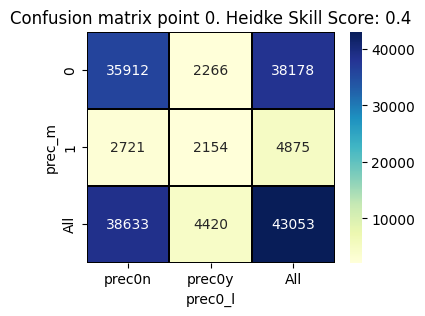

In [2]:
#@title Precipitation
df_prec =pd.concat([df_all[["prec0_l","prec0"]],station_raw['wxcodes_o']],axis=1).dropna()
df_prec["prec_m"] = [1 if "RA" in c or "DZ" in c else 0 for c in df_prec["wxcodes_o"]]
df_prec

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_prec.prec_m, df_prec.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

,visibility0,visibility_o
visibility0,1.000000,0.359638
visibility_o,0.359638,1.000000


,visibility0,visibility_o,visibility0_l
count,43053.000000,43053.000000,43053.000000
mean,22105.287582,8467.088031,9164.791861
std,6274.347124,3082.769165,2611.701321
min,22.216797,48.000000,100.000000
25%,24042.791016,8996.000000,9999.000000
50%,24096.853516,9994.000000,9999.000000
75%,24135.000000,9994.000000,9999.000000
max,24235.000000,9994.000000,9999.000000


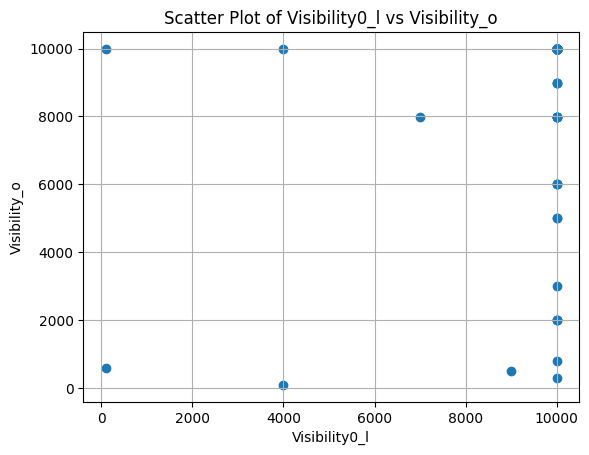

,visibility0,visibility_o,visibility0_l
time,,,
2022-01-26 06:00:00,24135.000000,9994.0,9999
2019-03-09 11:00:00,24041.265625,9994.0,9999
2019-07-15 07:00:00,24038.373047,354.0,9999
2022-02-13 23:00:00,24042.457031,8996.0,9999
2018-02-04 07:00:00,24080.099609,9994.0,9999
2019-04-30 17:00:00,24135.000000,9994.0,9999
2022-02-08 20:00:00,24135.000000,9994.0,9999
2019-12-19 12:00:00,24231.492188,6003.0,9999
2022-04-13 07:00:00,235.544800,9994.0,100


visibility0_l
9999    38716
100      2655
2000      321
3000      271
4000      248
5000      208
6000      164
7000      160
1000      135
8000      116
9000       59
Name: count, dtype: int64

In [3]:
#@title visibility0 vs visibility obs

def custom_round(value):
    if value > 9001:
        return 9999
    elif value < 1000:
        return 100
    else:
        return round(value / 1000) * 1000

df_vis = pd.concat([df_all["visibility0"],station_raw['visibility_o']],axis=1).dropna()
display(df_vis.corr())

# Define the old and new min and max values
old_min = 26.731182
old_max = 24235.0
new_min = 50
new_max = 9999

# Calculate the scale (a) and shift (b) factors
a = (new_max - new_min) / (old_max - old_min)
b = new_min - a * old_min

df_vis['visibility0_l'] = ((a * df_vis['visibility0'] + b).round().astype(int)).apply(custom_round)

display(df_vis.describe())
df_vis_s = df_vis.sample(100)
plt.scatter(df_vis_s['visibility0_l'], df_vis_s['visibility_o'])
plt.xlabel('Visibility0_l')
plt.ylabel('Visibility_o')
plt.title('Scatter Plot of Visibility0_l vs Visibility_o')
plt.grid(True)
plt.show()
display(df_vis.sample(30))
display(df_vis["visibility0_l"].value_counts())

,cfh0,cfl0,cfm0,visibility_o
cfh0,1.000000,0.064411,0.196387,-0.085702
cfl0,0.064411,1.000000,0.574333,-0.553060
cfm0,0.196387,0.574333,1.000000,-0.484193
visibility_o,-0.085702,-0.553060,-0.484193,1.000000


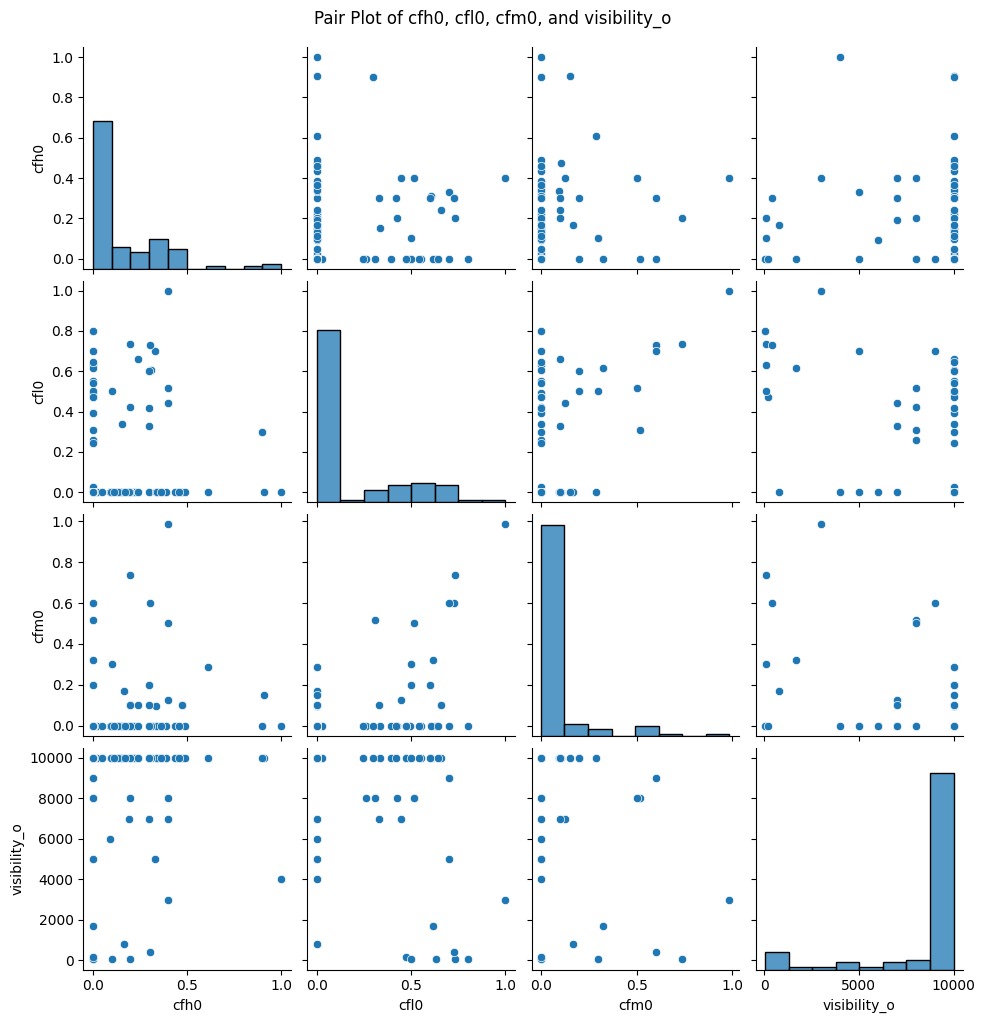

In [4]:
#@title Clouds
df_clo = pd.concat([df_all[['cfh0', 'cfl0', 'cfm0']],station_raw['visibility_o']],axis=1).dropna().sample(100)
display(df_clo.corr())
sns.pairplot(df_clo)
plt.suptitle('Pair Plot of cfh0, cfl0, cfm0, and visibility_o', y=1.02)
plt.show()


In [5]:
def transform_value(val):
    first_decimal = int(str(val)[2]) if len(str(val)) > 2 else 0
    return f'CL{first_decimal}'

df_all["cfl0"] = round(df_all["cfl0"],1)
df_all['cfl0_l'] = df_all['cfl0'].apply(transform_value)
df_all[["cfl0","cfl0_l"]]

,cfl0,cfl0_l
time,,
2018-01-02 00:00:00,0.5,CL5
2018-01-02 01:00:00,0.5,CL5
2018-01-02 02:00:00,0.5,CL5
2018-01-02 03:00:00,0.5,CL5
2018-01-02 04:00:00,0.5,CL5
...,...,...
2023-01-01 19:00:00,0.8,CL8
2023-01-01 20:00:00,0.5,CL5
2023-01-01 21:00:00,0.2,CL2


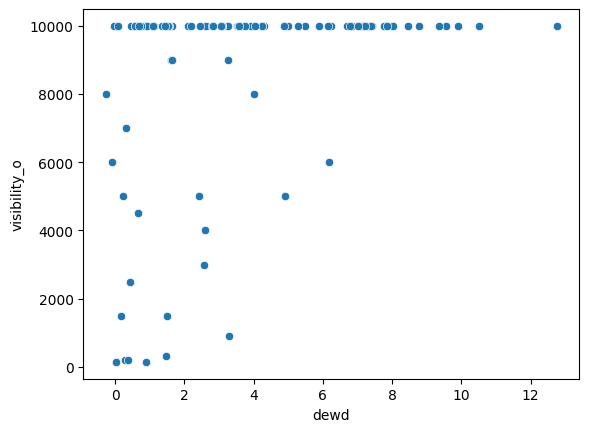

In [6]:
#@title Temperature minus temperature dew point
#dew_temperature = dry_temperature - (100 - relative_humidity) / 5
df_all["dewd"] = df_all["temp0"]-round(df_all["temp0"]- (100 - df_all["rh0"]*100) / 5,0)
vis = pd.concat([df_all["dewd"],station_raw["visibility_o"]],axis=1).dropna()
vis.describe()
sns.scatterplot(vis.sample(100),x="dewd",y="visibility_o");